## Building classifiers

Here will tune hyperparameters for models.

Starting with XGBoost...

In [ ]:
!git clone https://github.com/BA545-SP2019/2019-competition2-3-musketeers.git
 

Cloning into '2019-competition2-3-musketeers'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (489/489), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 489 (delta 319), reused 355 (delta 187), pack-reused 0
Receiving objects: 100% (489/489), 20.84 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (319/319), done.


In [ ]:
%cd 2019-competition2-3-musketeers/Kevin/

/content/2019-competition2-3-musketeers/Kevin


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from Modules import *
sns.set()
%matplotlib inline
import imblearn
import xgboost as xgb

In [2]:
#read in the data; data formated weird with extra column, 
#use only data we need
data = pd.read_csv('Data/Final_trimmed_sequential_data.csv')
df = data.iloc[:, 1:]
y = df['Y']

df.head()

AGE  Y  SEX_Female  SEX_Male  EDUCATION_Graduate School  EDUCATION_Other  \
0   24  1           1         0                          0                0   
1   26  1           1         0                          0                0   
2   34  0           1         0                          0                0   
3   37  0           1         0                          0                0   
4   57  0           0         1                          0                0   

   EDUCATION_University  MARRIAGE_Married  MARRIAGE_Non-married  \
0                     1                 1                     0   
1                     1                 0                     1   
2                     1                 0                     1   
3                     1                 1                     0   
4                     1                 1                     0   

   PERCENT_OF_LIMIT_BAL1      ...        PAY_4_Other  \
0               0.195650      ...                  0   
1               0.022350      ...                  1   
2               0.308011      ...                  1   
3               0.899800      ...                  1   
4               0.132340      ...                  1   

   PAY_4_more_than_two_month_late  PAY_4_on_time  PAY_4_one_month_late  \
0                               0              1                     0   
1                               0              0                     0   
2                               0              0                     0   
3                               0              0                     0   
4                               0              0                     0   

   PAY_5_Other  PAY_5_more_than_two_month_late  PAY_5_on_time  PAY_6_Other  \
0            1                               0              0            1   
1            1                               0              0            0   
2            1                               0              0            1   
3            1                               0              0            1   
4            1                               0              0            1   

   PAY_6_more_than_two_month_late  PAY_6_on_time  
0                               0              0  
1                               1              0  
2                               0              0  
3                               0              0  
4                               0              0  

[5 rows x 53 columns]

In [3]:
# set up the split data
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import sklearn.metrics
from imblearn.over_sampling import SMOTE

#1
X = df.drop(columns = ['Y'])
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .15, random_state = 2019)


In [4]:
#building a function to build XGBoost models
#will use xgb.cv function to tune to optimal number of estimators
import sklearn.metrics as metrics

Train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 2019)

target = 'Y'

def fit_model(model, dtrain, features, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
  
  if useTrainCV:
    xgb_params = model.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[features].values, label=dtrain[target].values)
    cv_results = xgb.cv(xgb_params, xgtrain, num_boost_round=model.get_params()['n_estimators'], 
                       nfold=cv_folds, metrics = ['auc', 'map'],
                       early_stopping_rounds = early_stopping_rounds, verbose_eval = 10,
                       as_pandas = True)
    model.set_params(n_estimators=cv_results.shape[0])
    
  #fit model to the data
  model.fit(dtrain[predictors], dtrain['Y'], eval_metric='auc')
    
  #predict on training set
  dtrain_predictions = model.predict(dtrain[predictors])
  dtrain_predprob = model.predict_proba(dtrain[predictors])[:,1]
    
  #print model report
  print("\nModel Report")
  print(f"Accuracy: {metrics.accuracy_score(dtrain['Y'].values, dtrain_predictions)}")
  print(f"AUC Score: {metrics.roc_auc_score(dtrain['Y'], dtrain_predprob)}")
    
  #plot feature importance
  xgb.plot_importance(model, max_num_features = 25)
  plt.figure(figsize = (12,8))
  plt.tight_layout()
  plt.show()
          

[0]	train-auc:0.740298+0.00864317	train-map:0.529644+0.00768954	test-auc:0.72674+0.00705127	test-map:0.508946+0.0102975
[10]	train-auc:0.785572+0.00178032	train-map:0.577363+0.00531084	test-auc:0.764747+0.0111241	test-map:0.544053+0.0144706
[20]	train-auc:0.79689+0.00196374	train-map:0.595877+0.00246936	test-auc:0.769482+0.00990971	test-map:0.546124+0.0129139
[30]	train-auc:0.808903+0.0013009	train-map:0.611668+0.00103096	test-auc:0.771156+0.00996814	test-map:0.548189+0.0140685
[40]	train-auc:0.819897+0.00106224	train-map:0.625345+0.00209934	test-auc:0.77237+0.00950145	test-map:0.547234+0.0142246
[50]	train-auc:0.828528+0.00157103	train-map:0.633907+0.00151331	test-auc:0.772694+0.00896224	test-map:0.547566+0.0140125
[60]	train-auc:0.837017+0.00147075	train-map:0.643228+0.00148312	test-auc:0.77266+0.00886728	test-map:0.546186+0.0140632
[70]	train-auc:0.844076+0.0019787	train-map:0.650588+0.00164196	test-auc:0.772057+0.00836361	test-map:0.54549+0.0141349
[80]	train-auc:0.850388+0.0021370

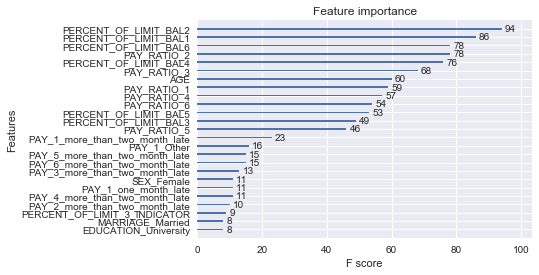

In [6]:
#set up parameters for function

predictors = [x for x in Train_data.columns if x not in [target]]

#create ratio for weighted scores
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb1 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators= 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = .8,
    colsample_bytree = .8,
    objecvtive = 'binary:logistic',
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1),
    seed = 2019
)

#run the function
fit_model(model = xgb1, dtrain = Train_data, features= predictors)

In [7]:
#save model to a file, in order to be loaded later
from sklearn.externals import joblib

#joblib.dump(xgb1,'Models/xgboost1.dat')


['Models/xgboost1.dat']

In [ ]:
#now tune max_depth and min_child_weight,
#two of most important hyperparamters

params_test1 = {
    'max_depth': range(2, 10, 2),
    'min_child_weight': range(1,9,2)
}

#define estimator with optimal num_estimators
estimator1 = xgb.XGBClassifier(learning_rate=0.1,
    n_estimators= 89,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = .8,
    colsample_bytree = .8,
    objecvtive = 'binary:logistic',
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1),
    seed = 2019
)

#define grid
grid_search1 = GridSearchCV(estimator=estimator1, param_grid=params_test1,
                           scoring = ['roc_auc', 'f1'], refit = 'f1', 
                            n_jobs = -1, cv = 5)

grid_search1.fit(Train_data[predictors], Train_data[target])

grid_search1.cv_results_, grid_search1.best_params_, grid_search1.best_score_

({'mean_fit_time': array([ 3.13191667,  3.2894474 ,  3.04709792,  2.88533549,  5.25971551,
          4.97215357,  4.94090605,  4.95764551,  7.85567932,  7.20350251,
          7.16163197,  7.30223861, 10.78908415,  9.67023787,  9.56467781,
         10.04321032]),
  'mean_score_time': array([0.04622083, 0.05217896, 0.04727001, 0.04965224, 0.06824021,
         0.06681318, 0.06857882, 0.06851702, 0.09415741, 0.08878651,
         0.09471836, 0.09481521, 0.12362175, 0.11434097, 0.11522875,
         0.11406198]),
  'mean_test_f1': array([0.53363778, 0.53415268, 0.53386645, 0.53386655, 0.53359679,
         0.53197394, 0.53283074, 0.53293479, 0.52839022, 0.53081496,
         0.53327534, 0.53231979, 0.52564909, 0.5223342 , 0.52935808,
         0.52605885]),
  'mean_test_roc_auc': array([0.77210533, 0.77283577, 0.77264481, 0.77249803, 0.77348992,
         0.77435895, 0.77542648, 0.77429708, 0.76912386, 0.77219615,
         0.77271523, 0.77471336, 0.76299214, 0.76417642, 0.76497943,
         0.767

In [ ]:
#fine tune around these hyperparamers
#previous grid was in steps of two
#here is steps of 1

params_test2 = {
    'max_depth': [1,2,3],
    'min_child_weight': [3,4,5]
}


estimator2 = xgb.XGBClassifier( n_estimators= 89,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = .8,
    colsample_bytree = .8,
    objecvtive = 'binary:logistic',
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1),
    seed = 2019
grid_search2 = GridSearchCV(estimator=estimator1, param_grid=params_test2,
                           scoring = ['roc_auc', 'f1'], refit = 'f1', 
                            n_jobs = -1, cv = 5)

grid_search2.fit(Train_data[predictors], Train_data[target])

grid_search2.cv_results_, grid_search2.best_params_, grid_search2.best_score_

({'mean_fit_time': array([2.33452249, 1.91400704, 1.91251421, 3.34325361, 2.99143624,
         2.85936422, 3.84760804, 3.87327991, 3.71470451]),
  'mean_score_time': array([0.03880606, 0.03833098, 0.03956394, 0.05442705, 0.05013127,
         0.05310726, 0.05608196, 0.0570055 , 0.05506134]),
  'mean_test_f1': array([0.53592108, 0.53592108, 0.53592108, 0.53415268, 0.53368357,
         0.53386645, 0.5339492 , 0.53258713, 0.53372444]),
  'mean_test_roc_auc': array([0.76173539, 0.76173539, 0.76173539, 0.77283577, 0.77288299,
         0.77264481, 0.77464161, 0.77474306, 0.77395523]),
  'mean_train_f1': array([0.5409863 , 0.5409863 , 0.5409863 , 0.54452672, 0.54431601,
         0.5444059 , 0.55668118, 0.55607504, 0.55628394]),
  'mean_train_roc_auc': array([0.76743503, 0.76743503, 0.76743503, 0.78765827, 0.7874295 ,
         0.78742703, 0.80573235, 0.80563901, 0.80548077]),
  'param_max_depth': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3],
               mask=[False, False, False, False, Fal

In [ ]:
#now we have otpimal max_depth and min_child_weight values
#next we will tune gamma

params_grid3 = {
    'gamma':  [0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.25, 0.4, 0.35, 0.4]
}

estimator3 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89, max_depth=1,
                               min_child_weight=3, 
                                gamma = 0, subsample = .8, colsample_bytree = .8, 
                                objecvtive = 'binary:logistic', 
                                scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1), 
                                seed = 2019)

#run the grid search
grid_search3 = GridSearchCV(estimator=estimator3, param_grid=params_grid3, scoring = ['roc_auc', 'f1'],
                             refit = 'f1', n_jobs = -1, cv = 5)

grid_search3.fit(Train_data[predictors], Train_data[target])

grid_search3.cv_results_, grid_search3.best_params_, grid_search3.best_score_

  

({'mean_fit_time': array([2.1450151 , 2.25126715, 2.03928194, 1.88422289, 1.89334855,
         1.89452639, 1.89883881, 1.90328083, 1.9094028 , 1.90344992]),
  'mean_score_time': array([0.0406713 , 0.04338055, 0.04029603, 0.03809581, 0.03771176,
         0.03746181, 0.03795953, 0.03690767, 0.03694267, 0.03683085]),
  'mean_test_f1': array([0.53592108, 0.53592108, 0.53592108, 0.53592108, 0.53592108,
         0.53592108, 0.53592108, 0.53592108, 0.53592108, 0.53592108]),
  'mean_test_roc_auc': array([0.76173539, 0.76173539, 0.76173539, 0.76173539, 0.76173539,
         0.76173539, 0.76173539, 0.76173539, 0.76173539, 0.76173539]),
  'mean_train_f1': array([0.5409863, 0.5409863, 0.5409863, 0.5409863, 0.5409863, 0.5409863,
         0.5409863, 0.5409863, 0.5409863, 0.5409863]),
  'mean_train_roc_auc': array([0.76743503, 0.76743503, 0.76743503, 0.76743503, 0.76743503,
         0.76743503, 0.76743503, 0.76743503, 0.76743503, 0.76743503]),
  'param_gamma': masked_array(data=[0.01, 0.04, 0.07, 0.1,

In [ ]:
#fine tune around 0.01

params_grid4 = {
    'gamma':  [0, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01]
}

estimator4 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89, max_depth=1,
                               min_child_weight=3, 
                                gamma = 0, subsample = .8, colsample_bytree = .8, 
                                objecvtive = 'binary:logistic', 
                                scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1), 
                                seed = 2019)

#run the grid search
grid_search4 = GridSearchCV(estimator=estimator4, param_grid=params_grid4, scoring = ['roc_auc', 'f1'],
                             refit = 'f1', n_jobs = -1, cv = 5)

grid_search4.fit(Train_data[predictors], Train_data[target])

grid_search4.cv_results_, grid_search4.best_params_, grid_search4.best_score_

({'mean_fit_time': array([1.87791748, 1.89993119, 1.90102639, 1.90042672, 1.97394891,
         2.24650693, 1.93531227]),
  'mean_score_time': array([0.03837757, 0.03747172, 0.03778181, 0.03724928, 0.04070206,
         0.0439621 , 0.03831224]),
  'mean_test_f1': array([0.53592108, 0.53592108, 0.53592108, 0.53592108, 0.53592108,
         0.53592108, 0.53592108]),
  'mean_test_roc_auc': array([0.76173539, 0.76173539, 0.76173539, 0.76173539, 0.76173539,
         0.76173539, 0.76173539]),
  'mean_train_f1': array([0.5409863, 0.5409863, 0.5409863, 0.5409863, 0.5409863, 0.5409863,
         0.5409863]),
  'mean_train_roc_auc': array([0.76743503, 0.76743503, 0.76743503, 0.76743503, 0.76743503,
         0.76743503, 0.76743503]),
  'param_gamma': masked_array(data=[0, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0},
   {'gamma': 0.001},
   {'gamma': 0.00

[0]	train-auc:0.641233+0.00218909	train-map:0.432786+0.00374373	test-auc:0.641265+0.00873119	test-map:0.431164+0.0185948
[1]	train-auc:0.650991+0.0175951	train-map:0.442431+0.0159696	test-auc:0.651515+0.0285462	test-map:0.440408+0.035373
[2]	train-auc:0.68068+0.0203444	train-map:0.472962+0.0205493	test-auc:0.680634+0.0207555	test-map:0.474996+0.0223388
[3]	train-auc:0.690518+0.00269103	train-map:0.482004+0.0054654	test-auc:0.690572+0.0107124	test-map:0.48218+0.0145349
[4]	train-auc:0.690518+0.00269103	train-map:0.482004+0.0054654	test-auc:0.690572+0.0107124	test-map:0.48218+0.0145349
[5]	train-auc:0.690518+0.00269103	train-map:0.482004+0.0054654	test-auc:0.690572+0.0107124	test-map:0.48218+0.0145349
[6]	train-auc:0.698599+0.00858111	train-map:0.486168+0.00754007	test-auc:0.699892+0.0196536	test-map:0.488887+0.0195379
[7]	train-auc:0.698599+0.00858111	train-map:0.486168+0.00754007	test-auc:0.699892+0.0196536	test-map:0.488887+0.0195379
[8]	train-auc:0.71133+0.00326985	train-map:0.494185

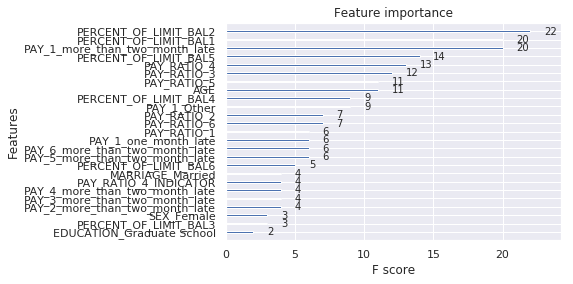

<Figure size 864x576 with 0 Axes>

In [ ]:
#recalibrate the number of boosting rounds

xgb2 = xgb.XGBClassifier(
    learning_rate = .1,
    n_estimators = 1000,
    max_depth = 1,
    min_child_weight = 3,
    gamma = 0,
    subsample = .8,
    colsample_bytree = .8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = (np.sum(y_train == 0) / np.sum(y_train == 1)),
    seed = 2019)

    
#find num_estimators for tuned xgb2
fit_model(xgb2, dtrain = Train_data, features = predictors )


The final parameters are:

max_depth: 1

min_child_weight: 3

gamma: 0

In [ ]:
#tune for the subsample and colsample_bytree hyperparamers

param_grid5 = {
    'subsample': [.4, .5, .6, .7, .8, .9],
    'colsample_bytree': [.4, .5, .6, .7, .8, .9]
}


grid_search5 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = .1, n_estimators = 265, max_depth = 1,
                                                         min_child_weight=3, 
                                                         gamma=0, subsample=.8,
                                                         colsample_bytree=.8, 
                                                         objective = 'binary:logistic', 
                                                         scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1)),
                                                         seed = 2019),
                            param_grid=param_grid5,
                            scoring = ['roc_auc', 'f1'], refit = 'f1', n_jobs = -1, cv=5)

grid_search5.fit(Train_data[predictors], Train_data[target])


                            

AttributeError: ignored

In [ ]:
grid_search5.cv_results_, grid_search5.best_params_, grid_search5.best_score_

({'mean_fit_time': array([4.47118015, 4.19599552, 4.21506743, 4.45569406, 4.39253244,
         4.05890284, 4.43345017, 4.5852685 , 4.63521438, 4.57204866,
         4.99158497, 4.51249032, 4.69586267, 4.90396118, 5.4630394 ,
         4.96491151, 5.26087623, 4.86395569, 4.98082981, 5.21834941,
         5.26606369, 5.22625475, 5.64868889, 5.38965354, 5.26206875,
         5.50783181, 5.59079499, 5.78735795, 5.79445939, 5.34845376,
         5.55488701, 5.83567953, 5.96928539, 6.36919956, 5.7961607 ,
         6.09050546]),
  'mean_score_time': array([0.06703348, 0.06996169, 0.06832724, 0.07447281, 0.07823348,
         0.06923447, 0.07701364, 0.0671998 , 0.06710367, 0.06825461,
         0.07581949, 0.07224321, 0.07139692, 0.06825991, 0.07807899,
         0.06781344, 0.07299266, 0.06692505, 0.06852798, 0.07071795,
         0.07178574, 0.07275114, 0.08046966, 0.06800671, 0.06856451,
         0.06822085, 0.06913428, 0.07256799, 0.07445388, 0.07116976,
         0.07193751, 0.06787953, 0.0702302 ,

In [ ]:
#apply regularization tuning


param_grid6 = {
 'reg_alpha':[1e-5, 1e-2, .1, 1, 100]
}

grid_search6 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = .1, n_estimators = 265, max_depth = 1,
                                                         min_child_weight=3, 
                                                         gamma=0, subsample=.5,
                                                         colsample_bytree=.6, 
                                                         objective = 'binary:logistic', 
                                                         scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1)),
                                                         seed = 2019),
                            param_grid=param_grid6,
                            scoring = ['roc_auc', 'f1'], refit = 'f1', n_jobs = -1, cv=5)

#train
grid_search6.fit(Train_data[predictors],Train_data[target])
grid_search6.cv_results_, grid_search6.best_params_, grid_search6.best_score_

({'mean_fit_time': array([5.16138606, 5.33548684, 5.53837156, 4.94785423, 4.72562971]),
  'mean_score_time': array([0.06877699, 0.07725754, 0.0735168 , 0.06848965, 0.06289897]),
  'mean_test_f1': array([0.53644704, 0.53633775, 0.53677805, 0.53580103, 0.53639422]),
  'mean_test_roc_auc': array([0.77001814, 0.77004956, 0.76999417, 0.76999819, 0.76138983]),
  'mean_train_f1': array([0.54263731, 0.54247305, 0.54289116, 0.54187181, 0.5382407 ]),
  'mean_train_roc_auc': array([0.78165952, 0.78164651, 0.78163507, 0.78148105, 0.76677781]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'rank_test_f1': array([2, 4, 1, 5, 3], dtype=int32),
  'rank_test_roc_auc': array([2, 1, 4, 3, 5], dtype=int32),
  'split0_test_f1': array([0.55013078, 0.5

In [ ]:
#fine tune around 0.1

param_grid7 = {
 'reg_alpha':[0.01, 0.05, .1, .15, .2, .4, .7]
}

grid_search7 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = .1, n_estimators = 265, max_depth = 1,
                                                         min_child_weight=3, 
                                                         gamma=0, subsample=.5,
                                                         colsample_bytree=.6, 
                                                         objective = 'binary:logistic', 
                                                         scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1)),
                                                         seed = 2019),
                            param_grid=param_grid7,
                            scoring = ['roc_auc', 'f1'], refit = 'f1', n_jobs = -1, cv=5)

#train
grid_search7.fit(Train_data[predictors],Train_data[target])
grid_search7.cv_results_, grid_search7.best_params_, grid_search7.best_score_

({'mean_fit_time': array([4.7971313 , 4.93104472, 5.06161585, 4.92331257, 5.46046848,
         4.91918302, 4.75737305]),
  'mean_score_time': array([0.06828909, 0.07765708, 0.07220297, 0.06822205, 0.07825923,
         0.06803732, 0.06423559]),
  'mean_test_f1': array([0.53633775, 0.53658529, 0.53677805, 0.53541431, 0.53460755,
         0.53637375, 0.53541245]),
  'mean_test_roc_auc': array([0.77004956, 0.77012019, 0.76999417, 0.76961895, 0.76978294,
         0.76971419, 0.76987765]),
  'mean_train_f1': array([0.54247305, 0.54310936, 0.54289116, 0.54274338, 0.54232889,
         0.54244351, 0.54224088]),
  'mean_train_roc_auc': array([0.78164651, 0.78168085, 0.78163507, 0.78156029, 0.78154733,
         0.78155073, 0.78168561]),
  'param_reg_alpha': masked_array(data=[0.01, 0.05, 0.1, 0.15, 0.2, 0.4, 0.7],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.01},
   {'reg_alpha': 0.05},
  

[0]	train-auc:0.641233+0.00218909	train-map:0.432786+0.00374373	test-auc:0.641265+0.00873119	test-map:0.431164+0.0185948
[1]	train-auc:0.681835+0.0197096	train-map:0.468594+0.0171348	test-auc:0.684056+0.0263988	test-map:0.468731+0.0296884
[2]	train-auc:0.681157+0.0194185	train-map:0.465881+0.0156959	test-auc:0.683345+0.0263738	test-map:0.468157+0.029417
[3]	train-auc:0.692045+0.00425537	train-map:0.478451+0.00458924	test-auc:0.692507+0.0110297	test-map:0.480681+0.0166308
[4]	train-auc:0.696076+0.00891427	train-map:0.481061+0.00840374	test-auc:0.697222+0.0123712	test-map:0.481737+0.0169625
[5]	train-auc:0.6989+0.0112218	train-map:0.487809+0.0117632	test-auc:0.69969+0.0134917	test-map:0.48412+0.0136856
[6]	train-auc:0.701708+0.0114796	train-map:0.489635+0.0117919	test-auc:0.703181+0.00781132	test-map:0.486314+0.0136122
[7]	train-auc:0.704583+0.0139542	train-map:0.494167+0.0157973	test-auc:0.707268+0.00812857	test-map:0.492319+0.0106851
[8]	train-auc:0.713025+0.0163748	train-map:0.498052+

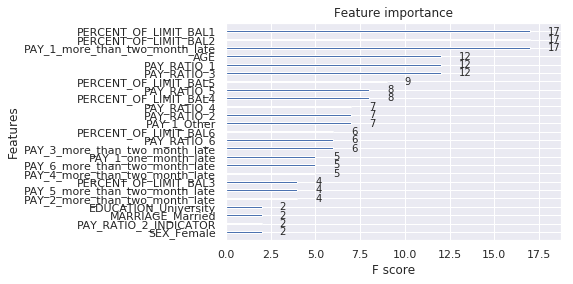

<Figure size 864x576 with 0 Axes>

In [ ]:
#apply regularized model to CV
#to see possible change in score

xgb3 = xgb.XGBClassifier(learning_rate = .1, n_estimators = 1000, max_depth = 1,
                         min_child_weight=3, gamma=0, 
                         subsample=.5,colsample_bytree=.6, 
                         objective = 'binary:logistic', 
                         scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1)),
                         seed = 2019,
                        reg_alpha = .1)

fit_model(model = xgb3, dtrain = Train_data, features = predictors )

[0]	train-auc:0.641233+0.00218909	train-map:0.432786+0.00374373	test-auc:0.641265+0.00873119	test-map:0.431164+0.0185948
[10]	train-auc:0.702436+0.0112624	train-map:0.493049+0.0125804	test-auc:0.702835+0.0138157	test-map:0.493742+0.0163531
[20]	train-auc:0.717276+0.00948424	train-map:0.503775+0.00850236	test-auc:0.714978+0.00775538	test-map:0.500357+0.0157243
[30]	train-auc:0.720149+0.0100991	train-map:0.505881+0.00780827	test-auc:0.718508+0.00889231	test-map:0.504855+0.0159346
[40]	train-auc:0.723697+0.00368332	train-map:0.508634+0.00363842	test-auc:0.723006+0.012798	test-map:0.502723+0.0139142
[50]	train-auc:0.724459+0.0056423	train-map:0.506998+0.00736355	test-auc:0.725324+0.0105308	test-map:0.507472+0.0157828
[60]	train-auc:0.727211+0.00499032	train-map:0.511181+0.00586042	test-auc:0.72746+0.0113668	test-map:0.508529+0.0134032
[70]	train-auc:0.726303+0.00426173	train-map:0.51027+0.00489463	test-auc:0.726873+0.0111124	test-map:0.506131+0.0113839
[80]	train-auc:0.728365+0.00436716	tr

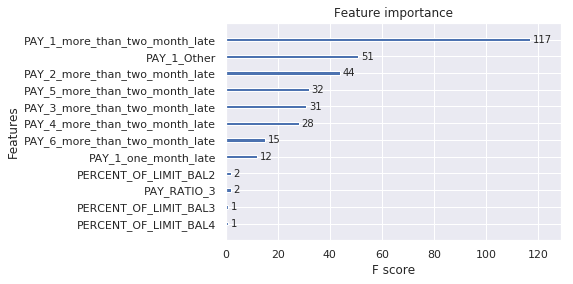

<Figure size 864x576 with 0 Axes>

In [ ]:
#lower the learning rate and add more trees
xgb4 = xgb.XGBClassifier(learning_rate = .01, n_estimators = 4000, max_depth = 1,
                         min_child_weight=3, gamma=0, 
                         subsample=.5,colsample_bytree=.6, 
                         objective = 'binary:logistic', 
                         scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1)),
                         seed = 2019,
                        reg_alpha = .1)

fit_model(model = xgb4, dtrain = Train_data, features = predictors )

In [ ]:
from sklearn.externals import joblib

joblib.dump(xgb3,'xgboost3.dat')
joblib.dump(xgb4,'xgboost4.dat')

['xgboost4.dat']

In [ ]:
loaded_model = joblib.load('xgboost3.dat')

y_pred = loaded_model.predict(test_data[predictors])
print(np.mean(accuracy_score(test_data[target], y_pred)))

0.7846666666666666
